In [1]:
# -*- coding: utf-8 -*-
"""
Created on May 27, 2024
Last modified on May 27, 2024
@Author: Guan-Fu Liu

To test the ChemEvo.py
"""
from ChemEvo import *

In [2]:
SFH = {}
SFH['File'] = f"./inputs/SFH.h5"
with h5py.File(SFH['File'], 'r') as f:
    SFH['Age'] = f['SFH/1Square'][...][:, 0]
    SFH['SFR'] = f['SFH/1Square'][...][:, 1]

SFE = 0.3
###### For comparison with galIMF ######
# yield_files = {"AGB+SNcc": "./inputs/NuPyCEE/portinari98_gce_in_igimf/yields1.h5",
#                 "SNIa": "./inputs/SNIa_TNH93/yields1.h5"}
# mass_lifetime_file = "./inputs/NuPyCEE/isotope_yield_table_portinari98_marigo01_gce_totalyields/yields1.h5"
# p_denominator=4.819420e-04
# p_numerator=1.575560e-04
# p_preset = p_numerator/p_denominator  #  The calibration factor of SNIa rate from galIMF
# out_file = "ChemEvo_galIMF_set.h5"
# comments = "To compare the result with that of galIMF"
###### For comparison with galIMF ######

###### For comparison with Nomoto et al. (2013) ######
yield_files = {
                "AGB+SNcc": "./inputs/NuPyCEE/agb_and_massive_stars_C15_N13_0_5_HNe/yields2.h5",
                # "AGB+SNcc": "./inputs/K10_N13_S16/agb_and_massive_stars_K10_N13/yields1.h5",
                "SNIa": "./inputs/NuPyCEE/sn1a_i99_W7/yields2.h5",
               }
mass_lifetime_file = "./inputs/NuPyCEE/agb_and_massive_stars_C15_N13_0_5_HNe/yields2.h5"
p_preset = None
out_file = "ChemEvo_N13.h5"
comments = "To compare the result with that of Nomoto et al. (2013)"
###### For comparison with Nomoto et al. (2013) ######

imf_dict = {"Salpeter": None}
ElemNotice = ["H", "He", "C", "N", "O", "Ne", "Si", "Mg", "S", "Ca", "Fe", "Other"]
interp_kind = "linear-linear"
SNIaOn = True
solar_set = "Default"
Z_0 = 0
output_dir = "./outputs"
def imf_evolve(Z_gas):
    if Z_gas < 0.02:
        return lambda m: m**(-1.3) if (m>=constants.Mstar_min and m<=constants.Mstar_max) else 0
    else:
        return lambda m: m**(-2.35) if (m>=constants.Mstar_min and m<=constants.Mstar_max) else 0

GasElement, ZGas, EjectElement, SNIaElement, SNccElement, AGB_Element, StarInitElement, YieldsTable,\
           SNIaNum, SNccNum, AGB_Num, Nstar, StellarMass = \
            ChemEvo(SFH, SFE, yield_files, imf_dict=imf_dict, imf_evolve=None, SNIaOn=SNIaOn, p_preset=p_preset,
                    mass_lifetime_file=mass_lifetime_file,
                    interp_kind=interp_kind, solar_set=solar_set, Z_0=Z_0, input_primodiral_gas=None,
                    ElemNotice=ElemNotice, 
                    output_dir=output_dir, out_file=out_file, comments=comments)

The elements you notice but not available in the yield table of SNIa, Z_0_02 are
 {'He', 'H'}
Step 0: Initialize the first age, the primordial gas


100%|██████████| 1363/1363 [00:08<00:00, 165.67it/s]


Step 1: Calculate the remaining ages


100%|██████████| 1362/1362 [24:04<00:00,  1.06s/it]


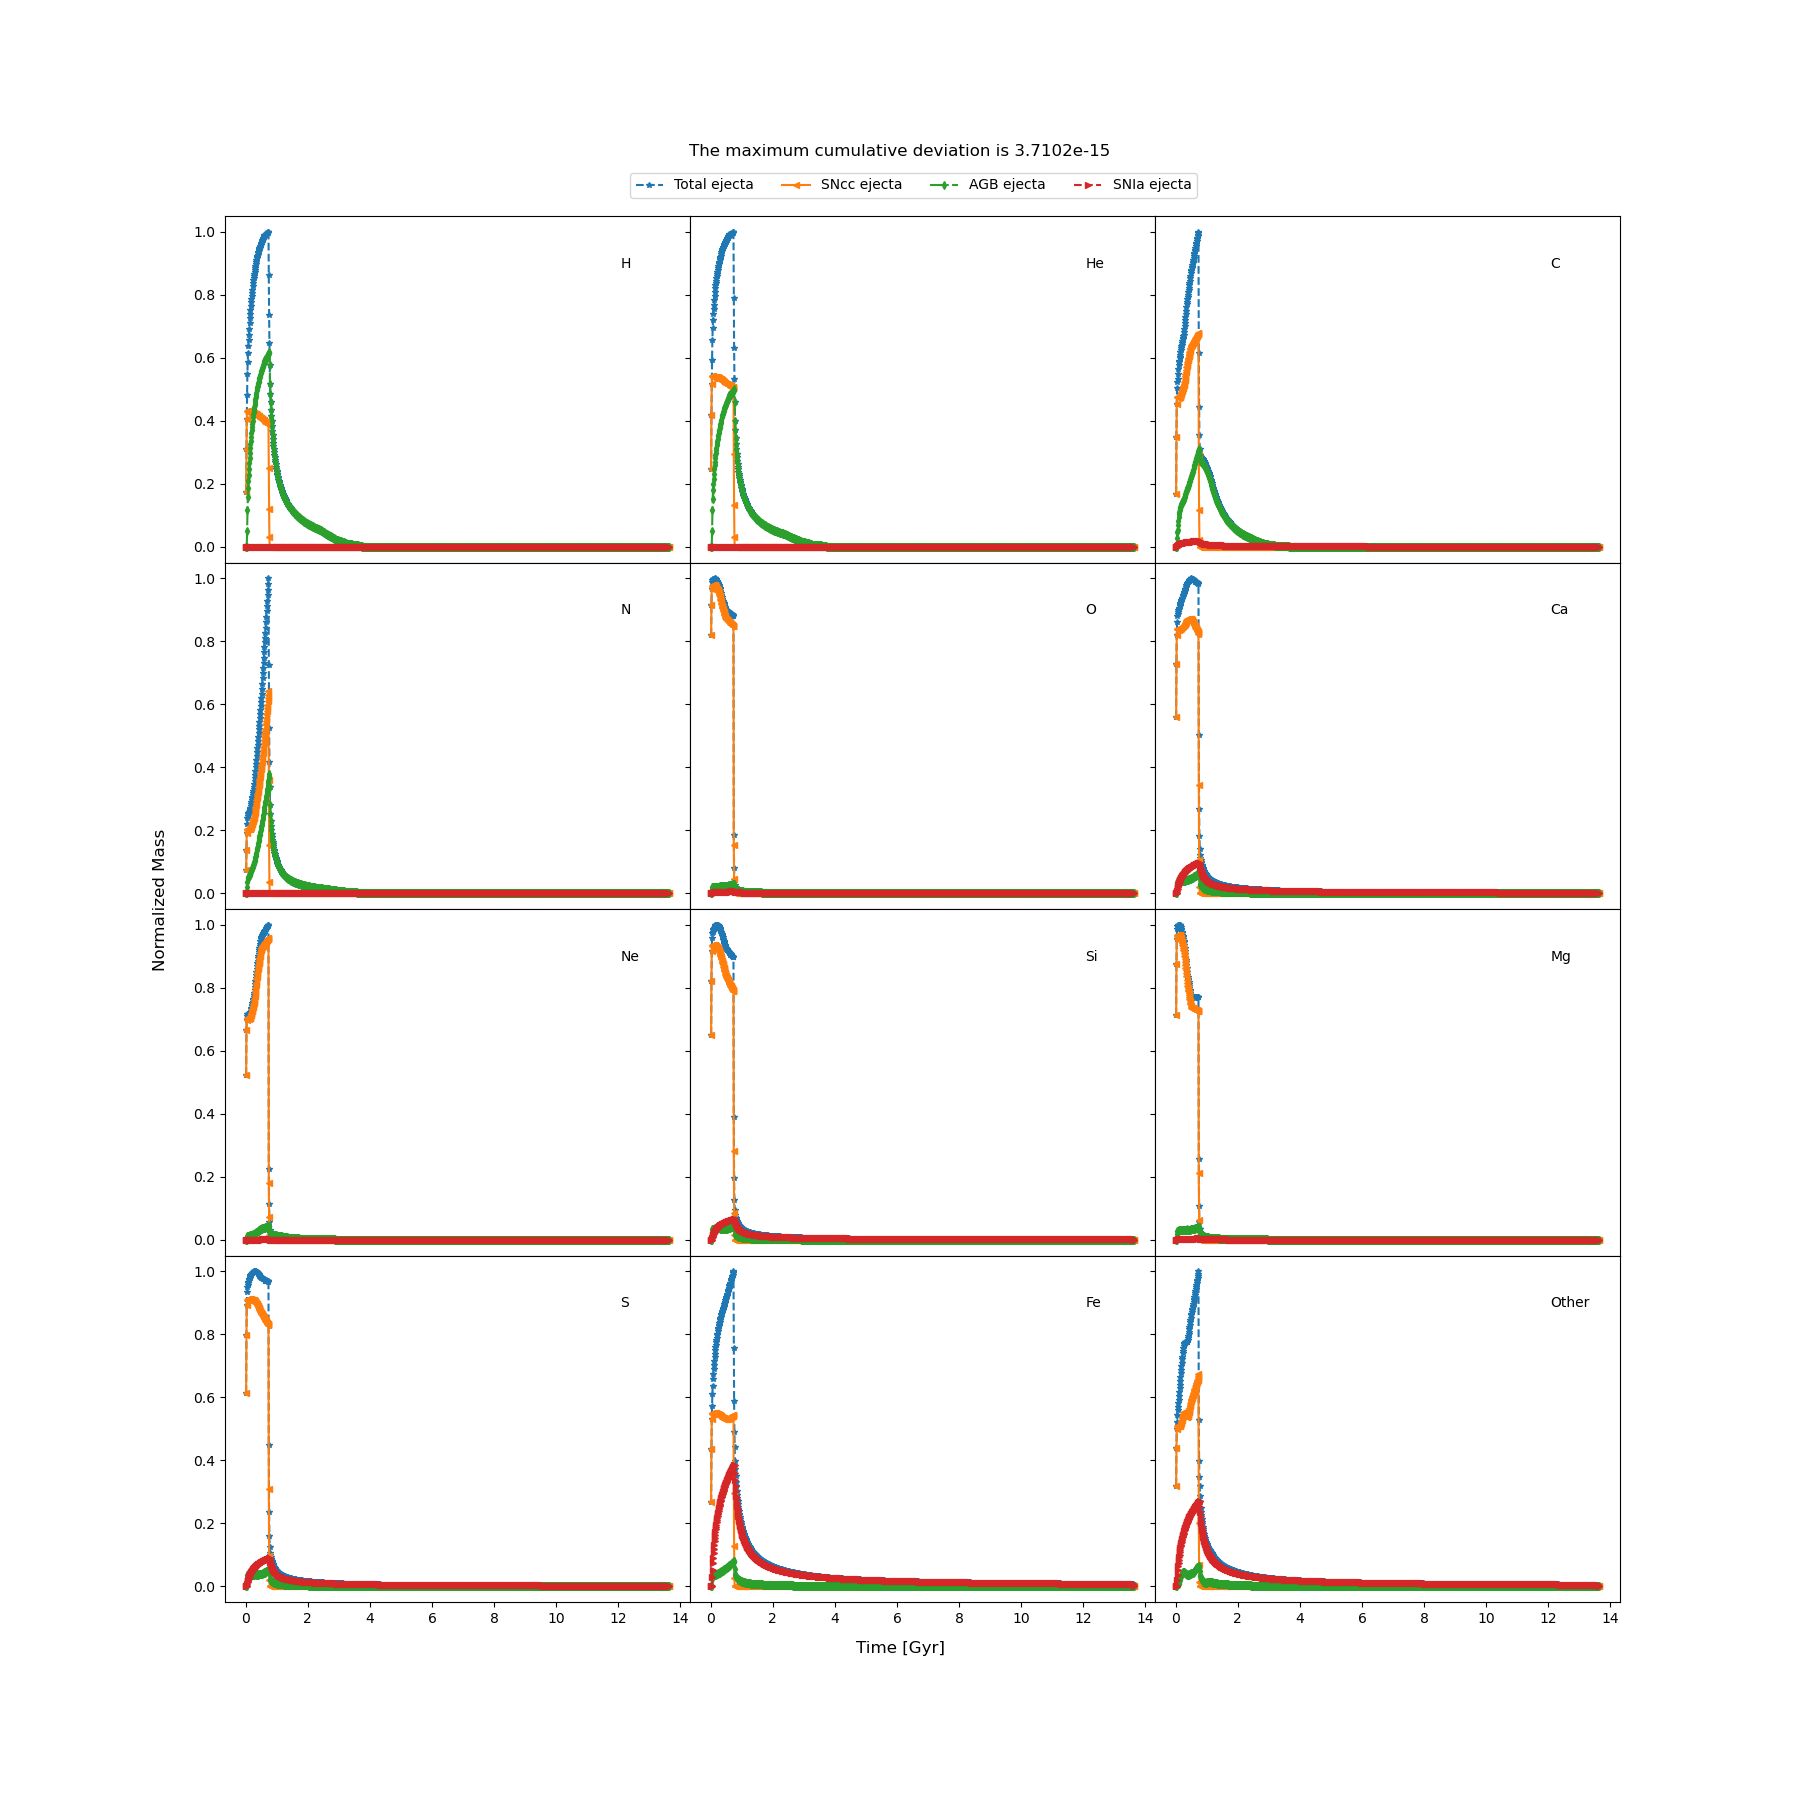

5.960464477539063e-08


In [17]:
from matplotlib.gridspec import GridSpec
%matplotlib widget
fig = plt.figure(figsize=(6*3, 4.5*4))
# fig.suptitle("Controlling subplot sizes with width_ratios and height_ratios")
gs = GridSpec(4, 3, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1, 1], wspace=0.0, hspace=0.0)
axes = { }
ElemNotice = ["H", "He", "C", "N", "O", "Ca", "Ne", "Si", "Mg", "S", "Fe", "Other"]
for i, elem in enumerate(ElemNotice):
    axes[elem] = fig.add_subplot(gs[i//3, i%3])
    norm = EjectElement[:, constants.elem_names.index(elem)].max()
    line1, = axes[elem].plot(SFH['Age']/1e9, EjectElement[:, constants.elem_names.index(elem)]/norm,
                              '--*', markersize=4, label="Total ejecta")
    line2, = axes[elem].plot(SFH['Age']/1e9, SNccElement[:, constants.elem_names.index(elem)]/norm,
                              '-<', markersize=4, label="SNcc ejecta")
    line3, = axes[elem].plot(SFH['Age']/1e9, AGB_Element[:, constants.elem_names.index(elem)]/norm,
                              '-.d', markersize=4, label="AGB ejecta")
    line4, = axes[elem].plot(SFH['Age']/1e9, SNIaElement[:, constants.elem_names.index(elem)]/norm,
                              '-->', markersize=4, label="SNIa ejecta")
    if i not in [9, 10, 11]:
        axes[elem].set_xticklabels([])
    if i not in [0, 3, 6, 9]:
        axes[elem].set_yticklabels([])
    axes[elem].annotate(elem, xy=(0.85, 0.85), xycoords='axes fraction')

fig.supxlabel("Time [Gyr]", y=0.08)
fig.supylabel(r"Normalized Mass", x=0.085)
fig.legend((line1, line2, line3, line4), ("Total ejecta", "SNcc ejecta", "AGB ejecta", "SNIa ejecta"), loc=(0.35, 0.89), ncol=4)
deviation = np.abs(EjectElement.cumsum(axis=0)-SNccElement.cumsum(axis=0)-AGB_Element.cumsum(axis=0)-SNIaElement.cumsum(axis=0))
mask = EjectElement>0
deviation = deviation[mask]
deviation = deviation / EjectElement.cumsum(axis=0)[mask]
deviation = deviation.max()
fig.suptitle("The maximum cumulative deviation is %0.4e" % deviation, y=0.92)
fig.savefig("Ejecta-all-N13.pdf", dpi=300)
plt.show()
print(np.abs(EjectElement-SNccElement-AGB_Element-SNIaElement).max())

In [16]:
print((EjectElement-SNccElement-AGB_Element-SNIaElement).min())

-5.960464477539063e-08


In [5]:
(np.abs(EjectElement-SNccElement-AGB_Element-SNIaElement)).max()

5.960464477539063e-08

In [6]:
np.unravel_index(np.argmax(np.abs(EjectElement-SNccElement-AGB_Element-SNIaElement)), EjectElement.shape)

(38, 1)

In [7]:
(EjectElement-SNccElement-AGB_Element)[0:50,6]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -8.73114914e-11,
        5.80921980e+03,  1.05556980e+04,  1.45687881e+04,  1.80450849e+04,
        2.11113960e+04,  2.38543047e+04,  2.63355674e+04,  2.86007829e+04,
        3.06845790e+04,  3.26138730e+04,  3.44100027e+04,  3.60901698e+04,
        3.76684442e+04,  3.91564808e+04,  4.05640428e+04,  4.18993896e+04,
        4.31695710e+04,  4.43806523e+04,  4.55378897e+04,  4.66458677e+04,
        4.77086094e+04,  4.87296639e+04,  4.97121788e+04,  5.06589579e+04,
        5.15725096e+04,  5.24550875e+04,  5.33087232e+04,  5.41352546e+04,
        5.49363503e+04,  5.57135290e+04,  5.64681777e+04,  5.72015657e+04,
        5.79148584e+04,  5.86091277e+04,  5.92853619e+04,  5.99444744e+04,
        6.05873109e+04,  6.12146558e+04,  6.18272383e+04,  6.24257372e+04,
        6.30107855e+04,  6.35829746e+04,  6.41428575e+04,  6.46909526e+04,
        6.52277460e+04,  6.57536942e+04])

In [8]:
SNIaNum[0:20], SNccElement[0:20,6]

(array([     0.        ,      0.        ,      0.        ,      0.        ,
        120270.21572452, 218538.13714861, 301622.48087136, 373593.41304646,
        437076.27429722, 493863.62877098, 545234.03951463, 592131.55019507,
        635273.0779801 , 675215.89391782, 712401.76591959, 747186.82609293,
        779862.36747038, 810669.68734368, 839810.91202844, 867457.04181744]),
 array([ 687751.41577631, 1435343.73752928, 1862614.41249809,
        1945808.01526445, 1943757.96748373, 1949405.6516713 ,
        1954109.71936137, 1955070.00169255, 1955366.56631522,
        1948994.62529246, 1943261.76237738, 1948252.407694  ,
        1956078.57462864, 1958659.33809454, 1974002.7426332 ,
        1988697.52947661, 2001705.10835014, 2014297.49969292,
        2026925.34181973, 2040702.97738289]))

In [9]:
SNIaElement[0:40,6]

array([    0.        ,     0.        ,     0.        ,     0.        ,
        5809.2197978 , 10555.69797767, 14568.78809756, 18045.08488092,
       21111.39595534, 23854.30467872, 26335.56743621, 28600.78285859,
       30684.57904875, 32613.87297848, 34410.00265639, 36090.16976184,
       37668.44415613, 39156.48083626, 40564.04278625, 41899.38955964,
       43169.57095615, 44380.65231713, 45537.88969932, 46645.86773951,
       47708.60935744, 48729.66392967, 49712.17881393, 50658.9578594 ,
       51572.50964514, 52455.08753731, 53308.72317584, 54135.25464277,
       54936.3502948 , 55713.52903706, 56468.1776572 , 57201.56571718,
       57914.85840414, 58609.12766717, 59285.36190734, 59944.47444056])

In [10]:
AGB_Element[0:40,6]

array([     0.        ,      0.        ,      0.        , 116557.76886498,
       189300.4900883 , 223108.29639792, 277617.43714156, 338403.70849192,
       388933.023121  , 426362.11907311, 454608.53217566, 475967.43691501,
       489950.32139679, 509422.72390951, 523799.49896886, 536080.20656951,
       547767.92293736, 557471.40600279, 565380.97446958, 572379.54577562,
       579814.32758877, 587322.75881144, 599348.93910034, 602541.60574496,
       611289.24274464, 622296.67410817, 632771.91245746, 644319.68520681,
       656653.47207531, 669580.30847839, 683196.04349235, 697011.12767883,
       710784.08977317, 723766.812115  , 744083.52631491, 747869.0029477 ,
       758446.55328969, 769877.22714455, 781418.7959617 , 791826.08445041])

In [11]:
SFH['Age'][35]/1e6

360.0

In [12]:
np.unravel_index(AGB_Element.argmax(), AGB_Element.shape)

(75, 1)

In [13]:
AGB_Element[:10, 1]

array([       0.        ,        0.        ,        0.        ,
       19073723.54341956, 44603082.69402896, 59541455.11793379,
       70920390.28448223, 79426591.82483229, 86449668.97619566,
       93548665.66596375])

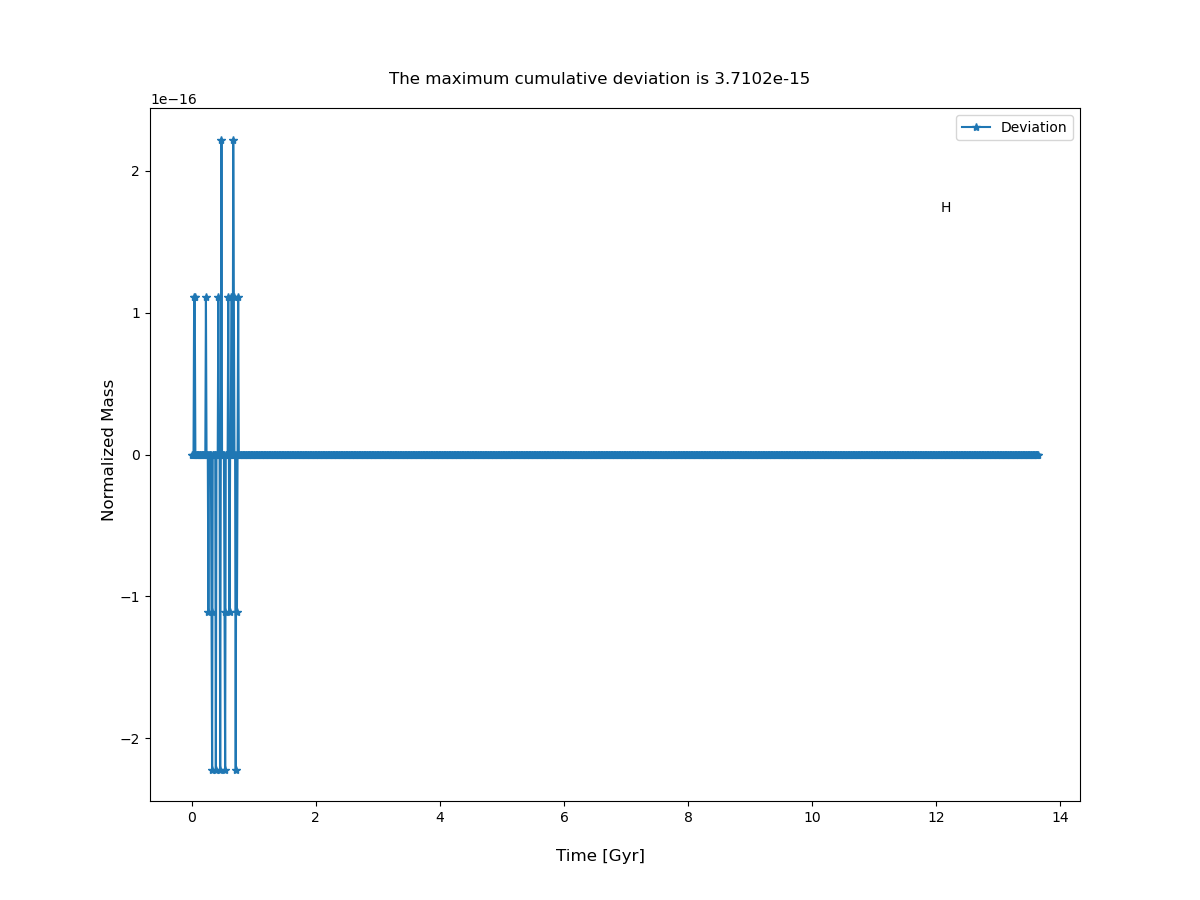

5.960464477539063e-08


In [14]:
from matplotlib.gridspec import GridSpec
%matplotlib widget
fig = plt.figure(figsize=(12,9))
# fig.suptitle("Controlling subplot sizes with width_ratios and height_ratios")
# gs = GridSpec(4, 3, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1, 1], wspace=0.0, hspace=0.0)
gs = GridSpec(1, 1, width_ratios=[1], height_ratios=[1], wspace=0.0, hspace=0.0)
axes = { }
ElemNotice = ["H"]
for i, elem in enumerate(ElemNotice):
    axes[elem] = fig.add_subplot(gs[i//3, i%3])
    norm = EjectElement[:, constants.elem_names.index(elem)].max()
    # line1, = axes[elem].plot(SFH['Age']/1e9, EjectElement[:, constants.elem_names.index(elem)]/norm,
    #                           '--*', markersize=4, label="Total ejecta")
    # line2, = axes[elem].plot(SFH['Age']/1e9, SNccElement[:, constants.elem_names.index(elem)]/norm,
    #                           '-<', markersize=4, label="SNcc ejecta")
    # line3, = axes[elem].plot(SFH['Age']/1e9, AGB_Element[:, constants.elem_names.index(elem)]/norm,
    #                           '-.d', markersize=4, label="AGB ejecta")
    # line4, = axes[elem].plot(SFH['Age']/1e9, SNIaElement[:, constants.elem_names.index(elem)]/norm,
    #                           '-->', markersize=4, label="SNIa ejecta")
    axes[elem].plot(SFH['Age']/1e9, (SNccElement[:, constants.elem_names.index(elem)]+
                                     AGB_Element[:, constants.elem_names.index(elem)]+
                                     SNIaElement[:, constants.elem_names.index(elem)])/norm-
                                     EjectElement[:, constants.elem_names.index(elem)]/norm, 
                                     '-*',
                                     label="Deviation")
    # if i not in [9, 10, 11]:
    #     axes[elem].set_xticklabels([])
    # if i not in [0, 3, 6, 9]:
    #     axes[elem].set_yticklabels([])
    axes[elem].annotate(elem, xy=(0.85, 0.85), xycoords='axes fraction')
    axes[elem].legend(loc='upper right')

fig.supxlabel("Time [Gyr]", y=0.04)
fig.supylabel(r"Normalized Mass", x=0.085)
# fig.legend((line1, line2, line3, line4), ("Total ejecta", "SNcc ejecta", "AGB ejecta", "SNIa ejecta"), loc=(0.35, 0.95), ncol=4)
deviation = np.abs(EjectElement.cumsum(axis=0)-SNccElement.cumsum(axis=0)-AGB_Element.cumsum(axis=0)-SNIaElement.cumsum(axis=0))
mask = EjectElement>0
deviation = deviation[mask]
deviation = deviation / EjectElement.cumsum(axis=0)[mask]
deviation = deviation.max()
fig.suptitle("The maximum cumulative deviation is %0.4e" % deviation, y=0.92)
# fig.savefig("Ejecta-all.pdf", dpi=300)
plt.show()
print(np.abs(EjectElement-SNccElement-AGB_Element-SNIaElement).max())